In [79]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

In [91]:
# Cargar el conjunto de datos
df = pd.read_csv('bank.csv', sep=';')
df.head()

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
0,30,unemployed,married,primary,no,1787,no,no,cellular,19,oct,79,1,-1,0,unknown,no
1,33,services,married,secondary,no,4789,yes,yes,cellular,11,may,220,1,339,4,failure,no
2,35,management,single,tertiary,no,1350,yes,no,cellular,16,apr,185,1,330,1,failure,no
3,30,management,married,tertiary,no,1476,yes,yes,unknown,3,jun,199,4,-1,0,unknown,no
4,59,blue-collar,married,secondary,no,0,yes,no,unknown,5,may,226,1,-1,0,unknown,no


In [92]:
# Preprocesamiento de datos
# Convertir columnas de tipo 'object' a numéricas usando factorize
df_processed = df.copy()
for col in df_processed.select_dtypes(include='object').columns:
    df_processed[col], _ = pd.factorize(df_processed[col])

print("\nPrimeras 5 filas del DataFrame después de la codificación de categóricas:")
df_processed.head()


Primeras 5 filas del DataFrame después de la codificación de categóricas:


,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
0,30,0,0,0,0,1787,0,0,0,19,0,79,1,-1,0,0,0
1,33,1,0,1,0,4789,1,1,0,11,1,220,1,339,4,1,0
2,35,2,1,2,0,1350,1,0,0,16,2,185,1,330,1,1,0
3,30,2,0,2,0,1476,1,1,1,3,3,199,4,-1,0,0,0
4,59,3,0,1,0,0,1,0,1,5,1,226,1,-1,0,0,0


In [82]:
# Escalar los datos
min_max_scaler = MinMaxScaler()
df_scaled = min_max_scaler.fit_transform(df_processed)
# df_scaled es ahora un array de NumPy, lo convertimos de nuevo a DataFrame para facilitar la visualización de componentes PCA
df_scaled_df = pd.DataFrame(df_scaled, columns=df_processed.columns)


In [94]:
# Aplicar PCA
# Reducimos a 2 componentes para visualización y simplificación
pca = PCA(n_components=2)
X_pca = pca.fit_transform(df_scaled_df) # Corregido: usar df_scaled_df (o df_scaled directamente)

print("\nPrimeras 5 filas de los componentes principales de PCA:")
print(pd.DataFrame(data=X_pca, columns=['PC1', 'PC2']).head())

print("\nCarga de los componentes principales (primeras 5 características):")
pd.DataFrame(np.transpose(pca.components_), columns=['PC1', 'PC2'], index=df_processed.columns).head()


Primeras 5 filas de los componentes principales de PCA:
        PC1       PC2
0 -0.408705  0.048686
1  0.534083  0.696806
2  0.437369 -0.326004
3  0.533013  0.787079
4  0.528564 -0.011291

Carga de los componentes principales (primeras 5 características):


,PC1,PC2
age,-0.062730,0.030086
job,-0.094545,0.012081
marital,-0.039615,-0.341671
education,-0.061555,-0.110363
default,0.001435,0.015542


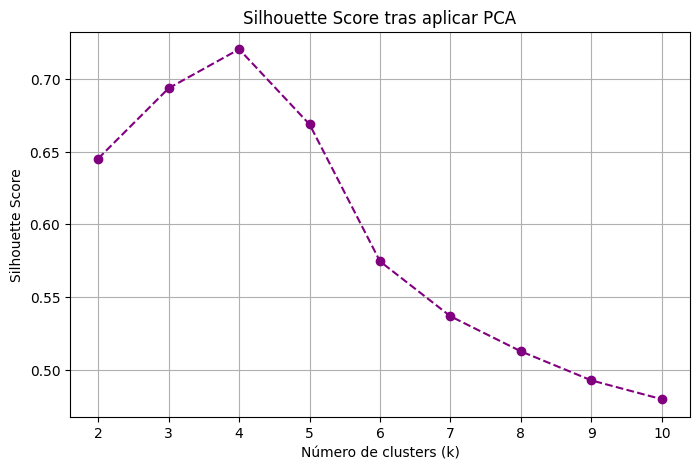

In [84]:
# Determinar el número óptimo de clusters usando Silhouette Score
silhouette_scores = {}
k_values = range(2, 11) # Probaremos de 2 a 10 clusters

for k in k_values:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init='auto') # n_init='auto' para suprimir advertencias futuras
    labels = kmeans.fit_predict(X_pca)
    score = silhouette_score(X_pca, labels)
    silhouette_scores[k] = score

# Visualizar Silhouette Score
plt.figure(figsize=(8, 5))
plt.plot(list(silhouette_scores.keys()), list(silhouette_scores.values()), marker='o', linestyle='--', color='purple')
plt.title("Silhouette Score tras aplicar PCA")
plt.xlabel("Número de clusters (k)")
plt.ylabel("Silhouette Score")
plt.grid(True)
plt.show()

In [ ]:
# Obtener el mejor Silhouette Score y el número de clusters correspondiente
best_silhouette_score = max(silhouette_scores.values())
n_clusters = max(silhouette_scores, key=silhouette_scores.get) # Forma más directa de obtener la clave del valor máximo

print(f"\nMejor puntuación de Silhouette: {best_silhouette_score:.4f}")
print(f"Mejor número de clusters (k): {n_clusters}")


Mejor puntuación de Silhouette: 0.7204
Mejor número de clusters (k): 4


In [87]:
# Aplicar KMeans con el número óptimo de clusters
kmeans_final = KMeans(n_clusters=n_clusters, random_state=42, n_init='auto')
cluster_labels = kmeans_final.fit_predict(X_pca)

# Mostrar etiquetas (primeros 10 para brevedad)
print(f"\nEtiquetas de los clusters para los primeros 10 puntos: {cluster_labels[:10]}")


Etiquetas de los clusters para los primeros 10 puntos: [0 3 1 3 1 0 1 1 1 3]


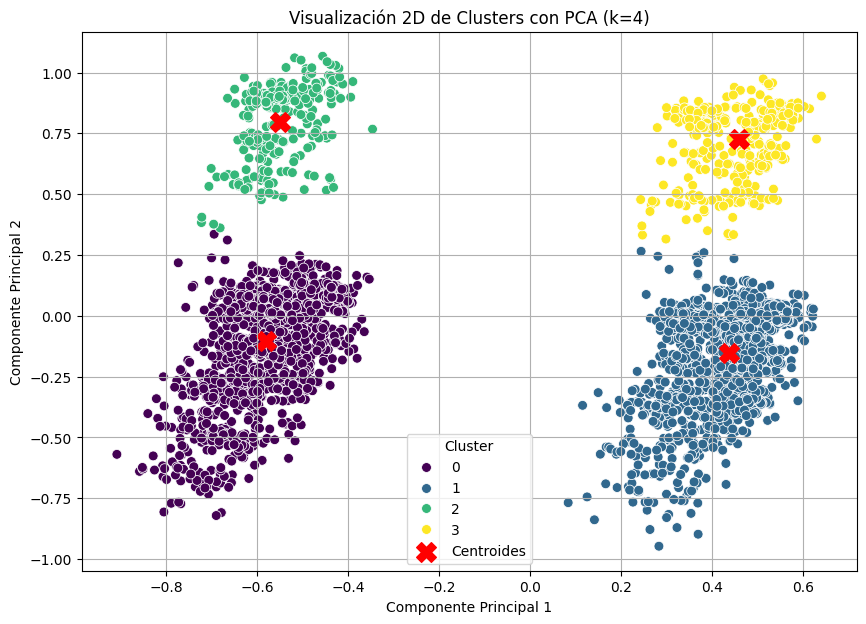

In [88]:
# Visualización de los clusters en 2D (si PCA tiene al menos 2 componentes)
if X_pca.shape[1] >= 2:
    plt.figure(figsize=(10, 7)) # Ajustado para mejor visualización
    sns.scatterplot(x=X_pca[:, 0], y=X_pca[:, 1], hue=cluster_labels, palette='viridis', s=50, legend='full')
    # Añadir centroides al gráfico
    centroids = kmeans_final.cluster_centers_
    plt.scatter(centroids[:, 0], centroids[:, 1], marker='X', s=200, color='red', label='Centroides')
    plt.title(f"Visualización 2D de Clusters con PCA (k={n_clusters})")
    plt.xlabel("Componente Principal 1")
    plt.ylabel("Componente Principal 2")
    plt.legend(title='Cluster')
    plt.grid(True)
    plt.show()

In [89]:
# Añadir resultados de clustering al DataFrame original (o al procesado)
df['cluster'] = cluster_labels # Usamos el df original para mantener todas las columnas originales
print("\nPrimeras 5 filas del DataFrame original con la columna 'cluster' añadida:")
print(df.head())

# Guardar el DataFrame final
output_filename = 'bank_final_clustered.csv'
df.to_csv(output_filename, index=False)
print(f"\nDataFrame final guardado en '{output_filename}'")


Primeras 5 filas del DataFrame original con la columna 'cluster' añadida:
   age          job  marital  education default  balance housing loan  \
0   30   unemployed  married    primary      no     1787      no   no   
1   33     services  married  secondary      no     4789     yes  yes   
2   35   management   single   tertiary      no     1350     yes   no   
3   30   management  married   tertiary      no     1476     yes  yes   
4   59  blue-collar  married  secondary      no        0     yes   no   

    contact  day month  duration  campaign  pdays  previous poutcome   y  \
0  cellular   19   oct        79         1     -1         0  unknown  no   
1  cellular   11   may       220         1    339         4  failure  no   
2  cellular   16   apr       185         1    330         1  failure  no   
3   unknown    3   jun       199         4     -1         0  unknown  no   
4   unknown    5   may       226         1     -1         0  unknown  no   

   cluster  
0        0  
1  